In [45]:
import numpy as np
import pandas as pd
import scipy.stats as st
import torch
from torch import distributions as dist
from tqdm.notebook import tqdm, trange

import statsmodels.formula.api as sm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import berp.synthesize_n400 as syn

In [107]:
DATASET_SIZE = 500
EPOCH_WINDOW = (-0.1, 0.5)
TEST_WINDOW = (0.35, 0.45)

In [105]:
X_word, X_phon, y_df = syn.sample_dataset_with_phons(DATASET_SIZE)

100%|███████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.30it/s]


In [108]:
epochs_df = syn.dataset_to_epochs(X_phon, y_df, 
                                  epoch_window=EPOCH_WINDOW, 
                                  test_window=TEST_WINDOW)

100%|██████████████████████████████████████████████████████████████| 34939/34939 [02:47<00:00, 208.91it/s]


In [109]:
y_all = epochs_df[["value_N400", "baseline_N400"]].unstack("phon_idx").fillna(0.)
X = X_word.surprisal.values
baseline = y_all.baseline_N400.to_numpy()
y = y_all["value_N400"].to_numpy()
assert len(X) == len(y_all)

## Quick viz

In [110]:
onsets = np.zeros(len(X)).astype(int)
y_0 = y[np.arange(len(X)), onsets]
baseline_0 = baseline[np.arange(len(X)), onsets]

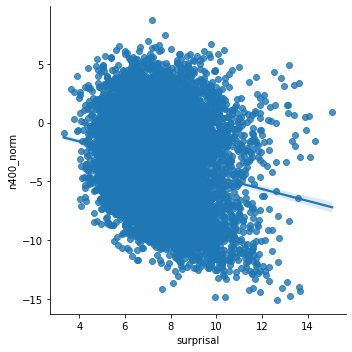

In [111]:
reg_data = pd.DataFrame({"surprisal": X.flatten(), "baseline": baseline_0, 
                         "n400": y_0, "n400_norm": y_0 - baseline_0})
sns.lmplot(data=reg_data, x="surprisal", y="n400_norm")

In [112]:
model = sm.ols("n400 ~ surprisal + baseline", data=reg_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   n400   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     574.1
Date:                Mon, 25 Apr 2022   Prob (F-statistic):          8.10e-235
Time:                        23:06:31   Log-Likelihood:                -22351.
No. Observations:                8638   AIC:                         4.471e+04
Df Residuals:                    8635   BIC:                         4.473e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2737      0.181    -12.560      0.000      -2.629      -1.919
surprisal     -0.5003      0.023    -21.946      0.000      -0.545      -0.456
baseline       0.3078      0.012     25.889      0.000       0.284       0.331
==============================================================================
Omnibus:                    13300.755   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              565.740
Skew:                           0.021   Prob(JB):                    1.42e-123
Kurtosis:                       1.747   Cond. No.                         45.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Alternating regression

In [113]:
word_lengths = X_phon.groupby(["item", "word_idx"]).size().to_numpy()
max_onsets = word_lengths - 1
# Pre-compute mask over (n_word, n_phon) matrix nulling out any n_phon columns which extend
# past word length for the corresponding word.
# Contains `False` where word-phoneme entry should be considered, and `True` elsewhere
y_mask = np.tile(np.arange(y.shape[1]), (y.shape[0], 1)) > max_onsets[:, np.newaxis]

In [114]:
recognition_p = 1 / 3.
weights = st.geom.pmf(np.arange(y.shape[1]) + 1, recognition_p)
weights

array([3.33333333e-01, 2.22222222e-01, 1.48148148e-01, 9.87654321e-02,
       6.58436214e-02, 4.38957476e-02, 2.92638317e-02, 1.95092212e-02,
       1.30061474e-02, 8.67076496e-03, 5.78050997e-03, 3.85367331e-03,
       2.56911554e-03, 1.71274370e-03, 1.14182913e-03, 7.61219420e-04,
       5.07479613e-04, 3.38319742e-04, 2.25546495e-04, 1.50364330e-04,
       1.00242887e-04, 6.68285911e-05, 4.45523940e-05, 2.97015960e-05,
       1.98010640e-05, 1.32007093e-05, 8.80047290e-06, 5.86698193e-06,
       3.91132129e-06, 2.60754753e-06, 1.73836502e-06])

In [123]:
n_iter = 10
# onsets = np.zeros(len(X)).astype(int)
onsets = np.random.randint(np.zeros(len(X)), max_onsets + 1)
best_mse, best_onsets = np.inf, None
for _ in trange(n_iter):
    model_fit = sm.ols(
        "n400 ~ surprisal + baseline",
        {"n400": y[np.arange(y.shape[0]), onsets],
         "baseline": baseline[np.arange(y.shape[0]), onsets],
         "surprisal": X}).fit()
    print(model_fit.mse_total, model_fit.params.loc["surprisal"])
    
    if model_fit.mse_total < best_mse:
        best_mse = model_fit.mse_total
        best_onsets = onsets
    
    # Compute residuals over all possible onset indices.
    ll = np.zeros_like(y)
    for onset in range(y.shape[1]):
        preds = model_fit.predict({"surprisal": X,
                                   "baseline": baseline[:, onset]})        
        ll[:, onset] = st.norm.pdf(y[:, onset], preds)
     
    # Don't allow anything past allowed onsets per word to be chosen.
    ll[y_mask] = 0.
    ll /= ll.sum(axis=1, keepdims=True)
    
    ll *= weights
    ll /= ll.sum(axis=1, keepdims=True)
    
    onsets = np.array([np.random.choice(y.shape[1], p=ps)
                       for ps in ll])
    # onsets = np.argmax(ll, axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

10.237690331208269 -0.6942482840820453
3.9266208222424397 -0.8456221358926419
3.759425637776687 -0.9406457695459725
3.786973391247767 -1.0041463693194443
3.802611285507264 -1.0215382212242827
3.8218074777573827 -1.0300273322297073
3.870508724659472 -1.0337872319843553
3.9765507874694617 -1.0512964436525474
3.9661576405100427 -1.0496181284004262
3.9307827748945026 -1.042121537994893


In [124]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   n400   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 1.012e+04
Date:                Tue, 26 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:59:42   Log-Likelihood:                -12955.
No. Observations:                8638   AIC:                         2.592e+04
Df Residuals:                    8635   BIC:                         2.594e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1491      0.061    -34.958      0.000      -2.270      -2.029
surprisal     -1.0421      0.008   -135.646      0.000      -1.057      -1.027
baseline       0.1705      0.004     43.588      0.000       0.163       0.178
==============================================================================
Omnibus:                       52.926   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.858
Skew:                          -0.160   Prob(JB):                     4.50e-13
Kurtosis:                       3.235   Cond. No.                         47.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
X_word["onset_pred"] = onsets

<AxesSubplot:xlabel='recognition_point', ylabel='onset_pred'>

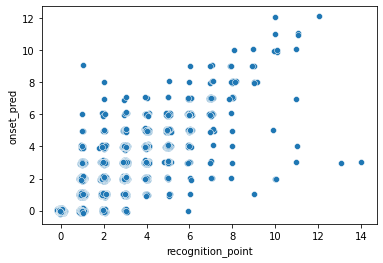

In [126]:
sns.scatterplot(data=X_word[["onset_pred", "recognition_point"]] + np.random.normal(0, 0.05, size=(len(X_word), 2)),
                x="recognition_point", y="onset_pred")

In [127]:
(X_word.recognition_point == X_word.onset_pred).mean()

0.6089372539939801

<AxesSubplot:ylabel='Count'>

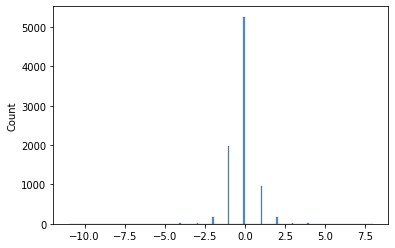

In [128]:
sns.histplot(X_word.onset_pred - X_word.recognition_point)

<AxesSubplot:xlabel='resid_normalized', ylabel='Count'>

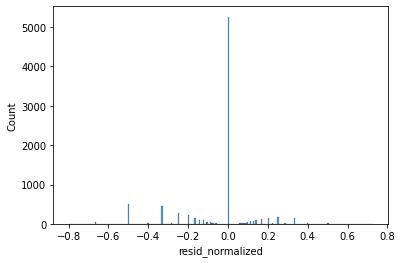

In [129]:
X_word["n_phon"] = X_phon.groupby(["item", "word_idx"]).size()
X_word["resid_normalized"] = (X_word.onset_pred - X_word.recognition_point) / X_word.n_phon
sns.histplot(X_word.resid_normalized)

In [130]:
import scipy.stats as st
st.pearsonr(X_word.recognition_point, X_word.onset_pred)

(0.8513568954354918, 0.0)